In [132]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [133]:
def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize =(6, 9), ncols =2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)


### Data handler

<AxesSubplot:>

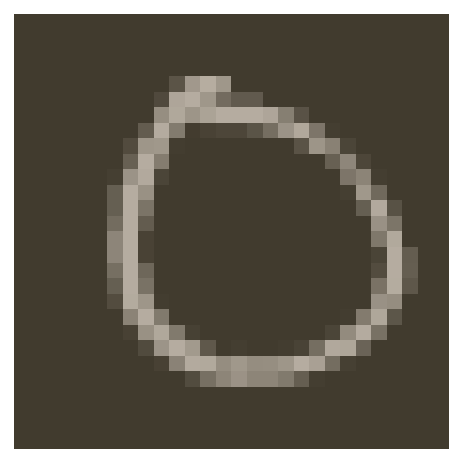

In [134]:
# Define a transformation to normalize the dataset
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])


# Download and load the training data
trainset = datasets.MNIST("MNIST_data/", download = True, train= True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 64, shuffle=True)


# Download and load the test data
testset = datasets.MNIST("MNIST_data/", download= True, train= False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 64, shuffle= True)



# Creating a function to visualize the dataset
def imshow(image, ax= None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))
   
  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

image, label = next(iter(trainloader))
imshow(image[0,:])

In [135]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [136]:
len(trainloader)

938

In [137]:
labels

tensor([7, 5, 2, 2, 1, 3, 8, 8, 9, 0, 2, 3, 1, 7, 6, 5, 6, 0, 2, 2, 0, 2, 0, 2,
        0, 8, 0, 3, 9, 1, 5, 8, 3, 9, 6, 6, 5, 2, 5, 9, 7, 6, 5, 2, 3, 6, 0, 7,
        8, 6, 9, 7, 6, 8, 6, 0, 2, 4, 7, 2, 0, 4, 8, 3])

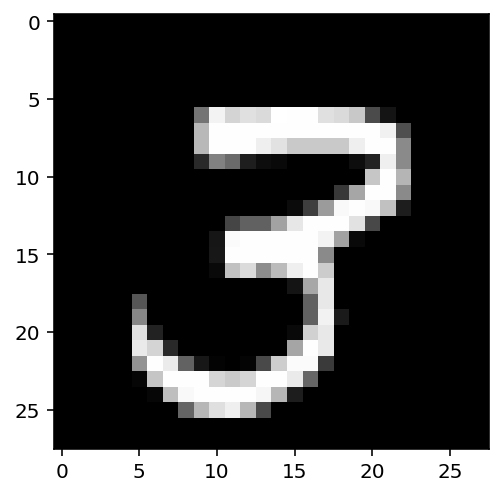

In [138]:
plt.imshow(images[63].numpy().squeeze(), cmap='Greys_r')

### CNN Model

In [139]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)     
        self.pool = nn.MaxPool2d(2, 2)       
        self.conv2 = nn.Conv2d(32, 16, 3)    
        self.fc1 = nn.Linear(16*5*5, 156)
        self.fc2 = nn.Linear(156, 84)
        self.fc3 = nn.Linear(84, 10)

        # Dropout module with a 0.2 drop probability 
        self.dropout = nn.Dropout(p=0.2)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)

        # flatten the input tensor
        x = x.view(x.shape[0], -1)   

        # Set the activation function
        layer1 = self.dropout(F.relu(self.fc1(x)))
        layer2 = self.dropout(F.relu(self.fc2(layer1)))
        out = F.softmax(self.fc3(layer2), dim=1)
    

        return out


net = Net()

#net(images).shape

In [140]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

Epoch: 1/30..  Training Loss 1.573..  Test Loss 1.487..  Test Accuracy 0.975
Epoch: 2/30..  Training Loss 1.495..  Test Loss 1.481..  Test Accuracy 0.981
Epoch: 3/30..  Training Loss 1.487..  Test Loss 1.478..  Test Accuracy 0.984
Epoch: 4/30..  Training Loss 1.483..  Test Loss 1.477..  Test Accuracy 0.984
Epoch: 5/30..  Training Loss 1.482..  Test Loss 1.482..  Test Accuracy 0.979
Epoch: 6/30..  Training Loss 1.481..  Test Loss 1.476..  Test Accuracy 0.986
Epoch: 7/30..  Training Loss 1.479..  Test Loss 1.477..  Test Accuracy 0.984
Epoch: 8/30..  Training Loss 1.479..  Test Loss 1.476..  Test Accuracy 0.986
Epoch: 9/30..  Training Loss 1.478..  Test Loss 1.477..  Test Accuracy 0.983
Epoch: 10/30..  Training Loss 1.477..  Test Loss 1.474..  Test Accuracy 0.987
Epoch: 11/30..  Training Loss 1.479..  Test Loss 1.473..  Test Accuracy 0.988
Epoch: 12/30..  Training Loss 1.477..  Test Loss 1.474..  Test Accuracy 0.987
Epoch: 13/30..  Training Loss 1.477..  Test Loss 1.475..  Test Accuracy 0

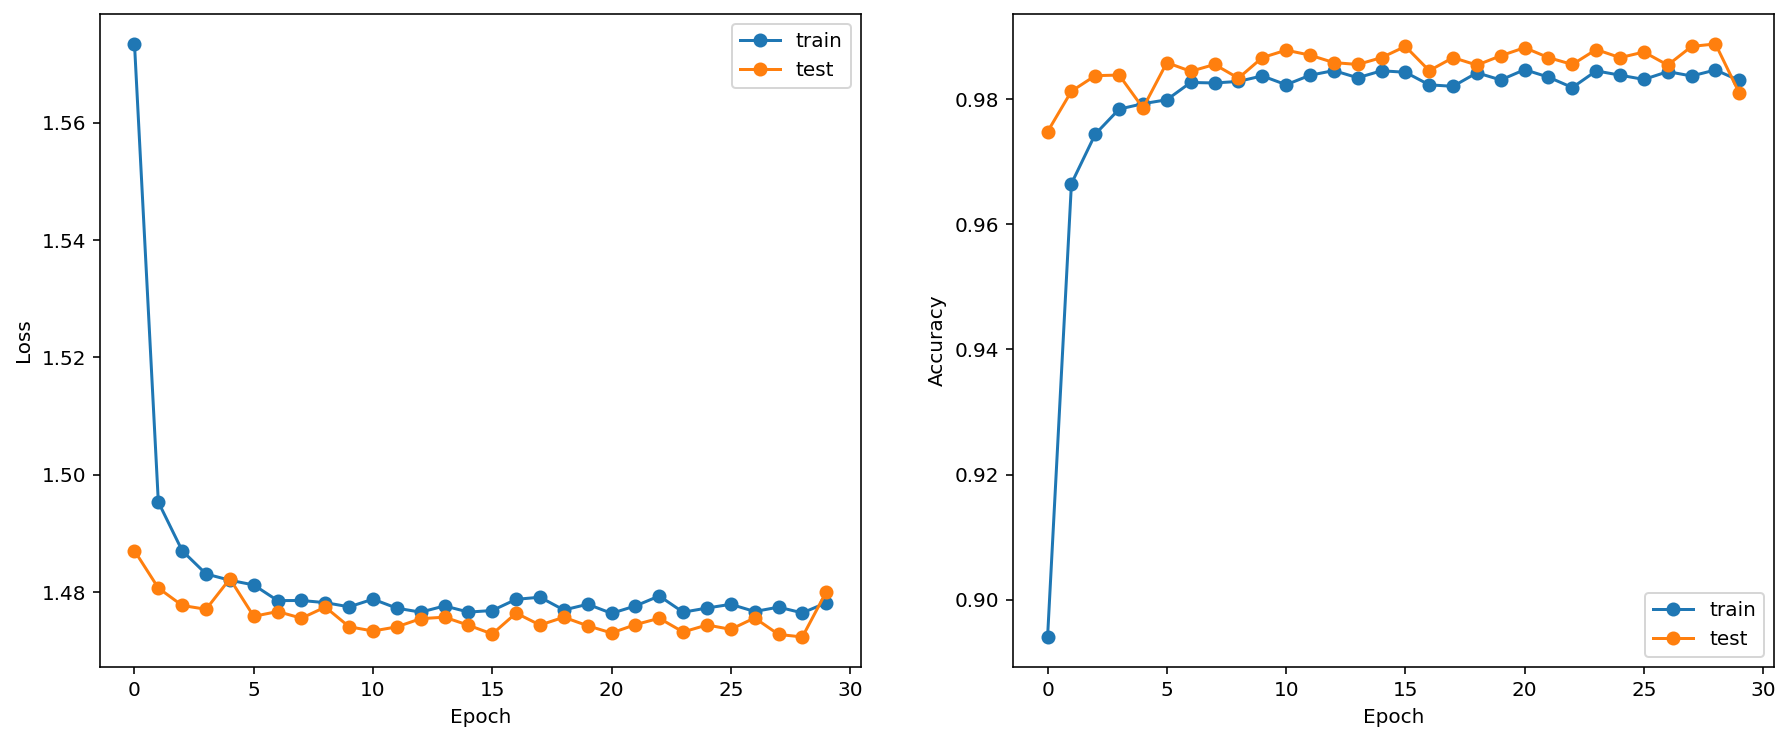

In [141]:
num_epochs = 30  


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []



for epoch in range(num_epochs):
    
    train_epoch_losses = 0
    train_accuracy = 0

    # training
    for images, labels in trainloader:

        # forward pass
        optimizer.zero_grad()
        output = net.forward(images)

        train_preds = torch.argmax(output.detach(), dim=1)
        
        # loss
        train_loss = criterion(output, labels)
        train_epoch_losses += train_loss.item()

        # train accuracy
        train_acc = (labels == train_preds).sum() / len(labels)
        train_accuracy += train_acc.item()

        # backward pass
        train_loss.backward()
        optimizer.step()


    
    # validation
    net.eval()

    with torch.no_grad():
        test_accuracy = 0
        test_epoch_losses = 0

        for imagest, labelst in testloader:
            
            test_output = net.forward(imagest)
            test_preds = torch.argmax(test_output, dim=1)
            test_acc = (labelst == test_preds).sum() / len(labelst)
            test_accuracy += test_acc
            test_loss = criterion(test_output, labelst)
            test_epoch_losses += test_loss
               
        
    net.train()


    # Get mean loss to enable comparison between train and test sets
    train_loss = train_epoch_losses/ len(trainloader)
    test_loss = test_epoch_losses / len(testloader)

    # mean accuracy
    trainaccu = train_accuracy / len(trainloader)
    testaccu = test_accuracy / len(testloader)

    
    # At completion of epoch
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(trainaccu)
    test_accuracies.append(testaccu)


    print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss {:.3f}.. ".format(train_loss),
              "Test Loss {:.3f}.. ".format(test_loss),
              "Test Accuracy {:.3f}".format(test_accuracy / len(testloader)))





# Plots
x_epochs = list(range(num_epochs))
plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Save model

In [142]:
torch.save(net.state_dict(), 'final_model.h5')

In [171]:
model = Net()
model.load_state_dict(torch.load('final_model.h5'))

<All keys matched successfully>

### Predict

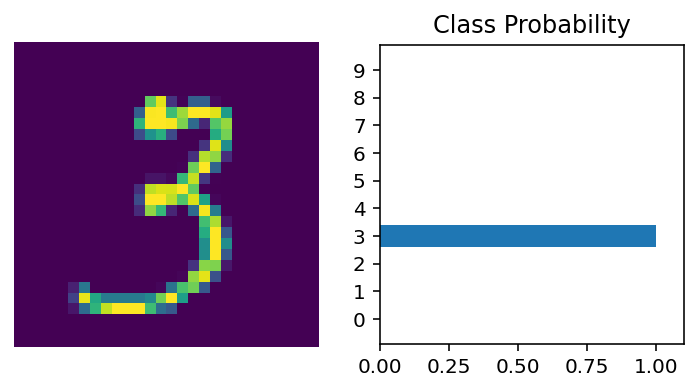

In [187]:
images, labels = next(iter(trainloader))

image = images[0]
#print(image.shape)

ps = model(image.unsqueeze(0))
#ps = F.softmax(logits, dim=1)                  # [F.softmax()] is used for if we are not giving any activation function inthe model we will give here,
view_classify(image,ps)                         # if we are using log_softmax in activation then we will use [torch.exp()]

### Predict with lopp

In [ ]:
import time

counter = 0
while counter < 10:                                    # while will loop the images

    index = np.random.randint(0, 64)                    # takinng randomly the images from batch-size = 64 
    images, labels = next(iter(testloader))
    
    image = images[index]    
    ps = model.forward(image.view(1, 1, 28, 28))
    #ps = F.softmax(logits, dim = 1)
    view_classify(image.view(1, 28, 28), ps)
    
    time.sleep(1)
    counter+=1